In [1]:
!nvidia-smi

Tue Sep 29 21:24:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0 Off |                  N/A |
| 57%   73C    P0    48W / 151W |     67MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1070    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   

In [2]:
!ls /kaggle/input/osic-pulmonary-fibrosis-progression

sample_submission.csv  test  test.csv  train  train.csv


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline

import SimpleITK as sitk

from scipy import ndimage
from skimage import measure

Matplotlib created a temporary config/cache directory at /.config/matplotlib because the default path (/tmp/matplotlib-85qe0dyn) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:

root = '/kaggle/input/osic-pulmonary-fibrosis-progression'

train_csv = os.path.join(root,'train.csv')
train_folder = os.path.join(root,'train')

test_csv = os.path.join(root,'test.csv')
test_folder = os.path.join(root,'test')

In [5]:
# https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b

import os
import SimpleITK as sitk
import pydicom
import traceback
from scipy import ndimage

def get_slice_location(dcm_file):
    ds = pydicom.dcmread(dcm_file)
    try:
        val = float(ds.SliceLocation)
    except:
        val = float('nan')
        
    return dcm_file, val

def imread(fpath):
    if os.path.isdir(fpath):
        
        file_list = os.listdir(fpath)
        file_loc_list = sorted([get_slice_location(os.path.join(fpath,x)) for x in file_list],key=lambda x:x[1])    
        dicom_names = [x[0] for x in file_loc_list]
        
        try:
            reader = sitk.ImageSeriesReader()
            reader.SetFileNames(dicom_names)
            img = reader.Execute()
        except:
            org_dicom_names = [x[0] for x in file_loc_list]
            dicom_names = []
            for x in org_dicom_names:
                try:
                    ds = pydicom.dcmread(x)
                    _=ds.pixel_array
                    dicom_names.append(x)
                except:
                    #traceback.print_exc()
                    pass
            reader = sitk.ImageSeriesReader()
            reader.SetFileNames(dicom_names)
            img = reader.Execute()
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
        img = reader.Execute()
        
        
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)
    
def _read_img(kind,patient_id):
    if kind == 'train':
        folder = train_folder
    else:
        folder = test_folder
    fpath = os.path.join(folder,patient_id)
    arr,spacing,origin,direction = imread(fpath)
    arr = arr.astype(np.int16)
    return arr,spacing,origin,direction


# naive lung with old school image processing technique!
def get_lung_mask(arr):
    
    bkgd = np.zeros(arr.shape).astype(np.uint8)
    bkgd[:,:,:2]=1
    bkgd[:,:,-2:]=1
    bkgd[:,:2,:]=1
    bkgd[:,-2:,:]=1
    
    # assume < 0 HU are voxels within lung
    procarr = (arr < -300).astype(np.int)
    procarr = ndimage.morphology.binary_closing(procarr,iterations=1)

    label_image, num = ndimage.label(procarr)
    region = measure.regionprops(label_image)

    region = sorted(region,key=lambda x:x.area,reverse=True)
    lung_mask = np.zeros(arr.shape).astype(np.uint8)
    
    # assume `x` largest air pockets except covering bkgd is lung, increase x for lung with fibrosis (?)
    x=3
    for r in region[:x]: # should just be 1 or 2, but getting x, since closing may not work.
        mask = label_image==r.label
        contain_bkgd = np.sum(mask*bkgd) > 0
        if contain_bkgd > 0:
            continue
        lung_mask[mask==1]=1
    
    lung_mask = ndimage.morphology.binary_dilation(lung_mask,iterations=3)
    
    return lung_mask


segment_list len: 120


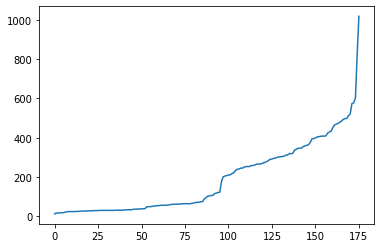

In [6]:
# get image count
count_dict = {}
for x in os.listdir(train_folder):
    count = len(os.listdir(os.path.join(train_folder,x)))
    count_dict[x]=count
plt.plot(sorted(count_dict.values()))


segment_list = [k for k,v in count_dict.items() if 40<v<600]
print('segment_list len:',len(segment_list))
# arbitrary grab 120 series based on image count.

In [ ]:
kind = 'train'
# check lung seg.
kwargs = {'aspect':1}
c=0
for n,patient in enumerate(segment_list):
    img,spacing,origin,direction = _read_img(kind,patient)
    mask = get_lung_mask(img)
    
    lung_voxel_count = np.sum(mask)
    total_voxel_count = np.prod(mask.shape)
    print(lung_voxel_count,total_voxel_count,lung_voxel_count/total_voxel_count)
    plt.figure(c)
    plt.subplot(121)
    plt.imshow(np.sum(img,axis=0),**kwargs)
    plt.subplot(122)
    plt.imshow(np.sum(mask,axis=0),**kwargs)
    
    c+=1
    if c > 5:
        break
        

In [7]:
img_root = 'image'
mask_root = 'mask'
cache_root = 'cache'
static_root = 'static'

raw_img_root = 'raw/img'
raw_mask_root = 'raw/mask'

os.makedirs(img_root,exist_ok=True)
os.makedirs(mask_root,exist_ok=True)
os.makedirs(static_root,exist_ok=True)
os.makedirs(cache_root,exist_ok=True)

os.makedirs(raw_img_root,exist_ok=True)
os.makedirs(raw_mask_root,exist_ok=True)

In [8]:
import json
from tqdm.notebook import tqdm

# perform lung seg.

if os.path.exists('lung_list.json'):
    with open('lung_list.json','r') as f:
        mydict = json.loads(f.read())
        lung_list = mydict['passed']
        failed_patient_list = mydict['failed']
else:
    failed_patient_list = []
    lung_list = []

kind = 'train'
for patient in tqdm(segment_list):
    
    img_path = os.path.join(img_root,f'{patient}.nii.gz')
    lung_mask_path = os.path.join(mask_root,f'{patient}.nii.gz')
    
    if os.path.exists(lung_mask_path) and os.path.exists(img_path):
        item = {
            'uid':patient,
            'img_path':img_path,
            'lung_mask_path':lung_mask_path
        }
        if item not in lung_list:
            lung_list.append(item)
        continue

    if patient in failed_patient_list:
        continue
    
    img,spacing,origin,direction = _read_img(kind,patient)
    mask = get_lung_mask(img)
    
    if img.shape[1] != 512 or img.shape[2] != 512:
        failed_patient_list.append(patient)
        continue
        
    lung_voxel_count = np.sum(mask)
    total_voxel_count = np.prod(mask.shape)
    lung_ratio = lung_voxel_count/total_voxel_count
    
    # qc. if lung mask too small, likely lung seg failed
    if lung_ratio < 0.05:
        failed_patient_list.append(patient)
        continue
        
    mask = mask.astype(np.uint8)
    imwrite(lung_mask_path,mask,spacing,origin,direction)    
    imwrite(img_path,img,spacing,origin,direction)
    
    lung_list.append({
        'uid':patient,
        'img_path':img_path,
        'lung_mask_path':lung_mask_path
    })
    
with open('lung_list.json','w') as f:
    mydict = {'passed':lung_list,'failed':failed_patient_list}
    f.write(json.dumps(mydict))

In [9]:
len(lung_list)

98

In [10]:
png_path_list = []
for item in tqdm(lung_list):
    patient = item['uid']
    img_path = item['img_path']
    lung_mask_path = item['lung_mask_path']
    png_path = os.path.join(cache_root,f'{patient}_mask_review.png')
    
    if item in failed_patient_list:
        continue
        
    if os.path.exists(png_path):
        png_path_list.append(png_path)
        continue
        
    img,spacing,origin,direction = imread(img_path)
    mask,spacing,origin,direction = imread(lung_mask_path)
    plt.subplot(121)
    plt.imshow(np.mean(img,axis=1),cmap='gray')
    plt.subplot(122)
    plt.imshow(np.mean(mask,axis=1),cmap='gray')
    plt.savefig(png_path)
    plt.close()
    png_path_list.append(png_path)

In [11]:
from IPython.core.display import display, HTML
htmltext = ''
for item in png_path_list:
    htmltext+=f"""{item}:<img src='{item}'> <br>"""
display(HTML(htmltext))
#print(htmltext)

In [13]:
visually_failed = [
    'ID00411637202309374271828',
    'ID00323637202285211956970',
    'ID00067637202189903532242',
    'ID00122637202216437668965',
    'ID00381637202299644114027'
]
failed_patient_list.append(visually_failed)

In [14]:

# for sake of simplicity save as individual slices

if os.path.exists('raw_list.json'):
    with open('raw_list.json','r') as f:
        raw_list = json.loads(f.read())
else:
    raw_list = []

for item in tqdm(lung_list):
    uid = item['uid']
    
    axial_img_path = os.path.join(raw_img_root,f'img_{uid}_0.npy')
    axial_mask_path = os.path.join(raw_mask_root,f'mask_{uid}_0.npy')

    tmp=dict(
        img=axial_img_path,
        mask=axial_mask_path,
    )
    if tmp in raw_list:
        continue

    if uid in failed_patient_list:
        continue
    
    img,spacing,origin,direction = imread(item['img_path'])
    mask,spacing,origin,direction = imread(item['lung_mask_path'])
    
    if img.shape[1] != 512 or img.shape[2] != 512:
        continue
    
    for x in range(img.shape[0]):
        try:
            axial_img_path = os.path.join(raw_img_root,f'img_{uid}_{x}.npy')
            axial_mask_path = os.path.join(raw_mask_root,f'mask_{uid}_{x}.npy')
            axial_img = img[x,:,:].squeeze().astype(np.int16)
            axial_mask = mask[x,:,:].squeeze().astype(np.uint8)
            np.save(axial_img_path,axial_img)
            np.save(axial_mask_path,axial_mask)
            
            raw_list.append(dict(
                img=axial_img_path,
                mask=axial_mask_path,
            ))
        except:
            pass
        
with open('raw_list.json','w') as f:
    f.write(json.dumps(raw_list))

In [15]:
! ls raw/img | wc -l
! ls raw/mask | wc -l

23800
23800


In [16]:
len(raw_list)

18346

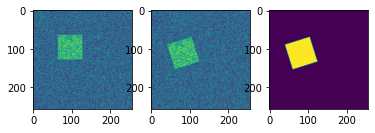

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as A

image = np.random.rand(256,256)
image[64:128,64:128]+=0.5
mask = np.zeros((256,256))
mask[64:128,64:128]=1

plt.subplot(131)
plt.imshow(image)

aug_pipeline = A.Compose([
    A.ShiftScaleRotate(p=0.5),    
])

augmented = aug_pipeline(
    image=image,
    mask=mask,
)

plt.subplot(132)
plt.imshow(augmented['image'])
plt.subplot(133)
plt.imshow(augmented['mask'])

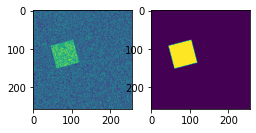

In [18]:

augmented = aug_pipeline(
    image=image,
    mask=mask,
)

plt.subplot(132)
plt.imshow(augmented['image'])
plt.subplot(133)
plt.imshow(augmented['mask'])

In [19]:

#https://gist.github.com/pangyuteng/fdbf0e13cd9173dc11aabccb30f8a2ad

import pandas as pd
import numpy as np
import albumentations as A

aug_pipeline = A.Compose([
    A.ShiftScaleRotate(p=0.5),    
])

def readimage(image_file,mask_file,augment):

    _x_sample = np.load(image_file).astype(np.float)
    x_sample = np.copy(_x_sample)
    
    y_mask = np.load(mask_file)
    y_mask = y_mask.astype(np.float)
    
    minval,maxval = -1000,1000
    x_sample = (x_sample-minval)/(maxval-minval)
    x_sample = x_sample.clip(0,1)
        
    # initialize zero mean noise
    minval,maxval = -1000,-400
    y_sample = (_x_sample-minval)/(maxval-minval)
    y_sample = y_sample.clip(0,1)
    
    y_sample[y_mask==0] = 0
    
    y_sample = np.expand_dims(y_sample,axis=-1)
    y_mask = np.expand_dims(y_mask,axis=-1)
    y_sample = np.concatenate([y_sample,y_mask],axis=-1)
    
    augmented = aug_pipeline(
        image=x_sample,
        mask=y_sample,
    )
    x_sample = augmented['image']
    y_sample = augmented['mask']
    
    x_sample = np.expand_dims(x_sample,axis=-1)
    
    return x_sample, y_sample

# https://github.com/keras-team/keras/issues/9707

from tensorflow.keras.utils import Sequence
class MyDataGenerator(Sequence):
    def __init__(self,data_list,batch_size=8,shuffle=True,augment=False):
        self.y = np.array([x['mask'] for x in data_list])
        self.x = np.array([x['img'] for x in data_list])
        
        self.indices = np.arange(len(self.y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        if self.shuffle:
            inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_x = self.x[inds]
            batch_y = self.y[inds]
        else:
            batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
            
        # read your data here using the batch lists, batch_x and batch_y
        x = []
        y = []
        for image_file,mask_file, in zip(batch_x,batch_y):
            ix,iy=readimage(image_file,mask_file,self.augment)
            x.append(ix)
            y.append(iy)

        x,y = np.asarray(x, dtype=np.float), np.asarray(y, dtype=np.float)
        #print(type(x),type(y),x.shape,y.shape)
        return x,y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [20]:
len(raw_list)

18346

(15, 512, 512, 1) (15, 512, 512, 2)
1.0 0.0
1.0 0.0


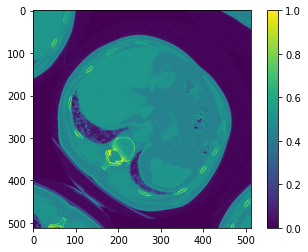

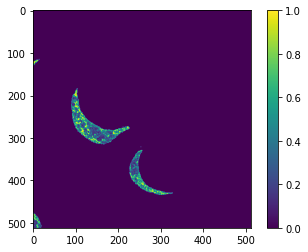

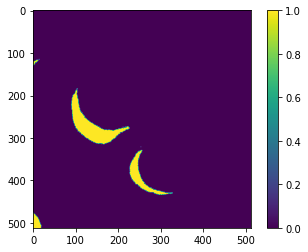

In [21]:
batch_size = 15
dg = MyDataGenerator(raw_list,batch_size=batch_size)

len(raw_list)/batch_size
x,y = dg[50]
print(x.shape,y.shape)

ind = 10
plt.figure(0)
plt.imshow(x[ind,:])
plt.colorbar()
plt.figure(1)
plt.imshow(y[ind,:,:,0])
plt.colorbar()
plt.figure(2)
plt.imshow(y[ind,:,:,1])
plt.colorbar()

print(np.max(x[ind,:]),np.min(x[ind,:]))
print(np.max(y[ind,:]),np.min(y[ind,:]))

In [34]:

# https://keras.io/examples/vision/oxford_pets_image_segmentation/

from tensorflow import keras
from tensorflow.keras import layers


def get_lung_feat_model():
    
    img_size = (512,512)
    num_classes = 1
    
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x) # <--- ... 
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
            
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    mid = x
    for filters in [256, 128, 64, 32]:
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    # Add a per-pixel classification layer
    intensity = layers.Conv2D(num_classes, 3, activation="linear", padding="same")(x)
    mask = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    outputs = layers.Concatenate(axis=-1)([intensity,mask])
    
    #
    #************************************************* ^^^^^^^^^^^ ************************************************* 
    #                                            linear/sigmoid 
    
    # Define the model
    model = keras.Model(inputs, outputs)
    model_alt = keras.Model(inputs, [outputs,mid])
    return model, model_alt

keras.backend.clear_session()
# Build model
model, model_alt = get_lung_feat_model()
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [35]:
from sklearn.model_selection import train_test_split
X_tt, X_test, y_tt, y_test = train_test_split(raw_list,raw_list,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tt,y_tt,test_size=0.25, random_state=42)

print('6:2:2')
print(len(X_train))
print(len(X_val))
print(len(X_test))

6:2:2
11007
3669
3670


In [43]:
import tensorflow as tf

batch_size = 8
epochs = 50

keras.backend.clear_session()
# Build model
model, model_alt = get_lung_feat_model()
#model.summary()

def mse_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
    
def bc_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

def mloss(_lambda):
    def loss(y_true, y_pred):
        return \
            _lambda * mse_loss(y_true[:,:,:,0], y_pred[:,:,:,0]) + \
            (1 - _lambda)*bc_loss(y_true[:,:,:,1], y_pred[:,:,:,1])
    return loss



opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=mloss(0.8))

callbacks = [
    keras.callbacks.ModelCheckpoint("lung_feat.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
train_gen = MyDataGenerator(X_train,batch_size=batch_size)
val_gen = MyDataGenerator(X_val)
history = model.fit(train_gen,epochs=epochs, validation_data=val_gen, callbacks=callbacks)

model_alt.save_weights('latent.h5')

Epoch 1/50
1375/1375 [==============================] - 802s 584ms/step - loss: 1.8980 - val_loss: 0.0345
Epoch 2/50
1375/1375 [==============================] - 799s 581ms/step - loss: 0.0300 - val_loss: 0.0216
Epoch 3/50
1375/1375 [==============================] - 798s 581ms/step - loss: 0.0234 - val_loss: 0.0199
Epoch 4/50
1375/1375 [==============================] - 799s 581ms/step - loss: 0.0193 - val_loss: 0.0208
Epoch 5/50
1375/1375 [==============================] - 797s 579ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 6/50
1375/1375 [==============================] - 795s 579ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 7/50
1375/1375 [==============================] - 794s 578ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 8/50
1375/1375 [==============================] - 794s 578ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 9/50
1375/1375 [==============================] - 795s 578ms/step - loss: 0.0120 - val_loss: 0.0149
Epoch 10/50
1375/1375 [=======================

<AxesSubplot:>

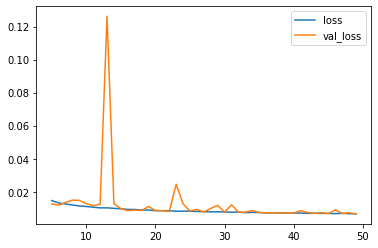

In [51]:
lossdf = pd.DataFrame(history.history)
lossdf[['loss','val_loss']].loc[5:].plot()

In [46]:
test_gen = MyDataGenerator(X_test)
model.load_weights('lung_feat.h5')
model.evaluate(test_gen)

458/458 [==============================] - 136s 298ms/step - loss: 0.0067


0.00671944348141551

(8, 512, 512, 2)


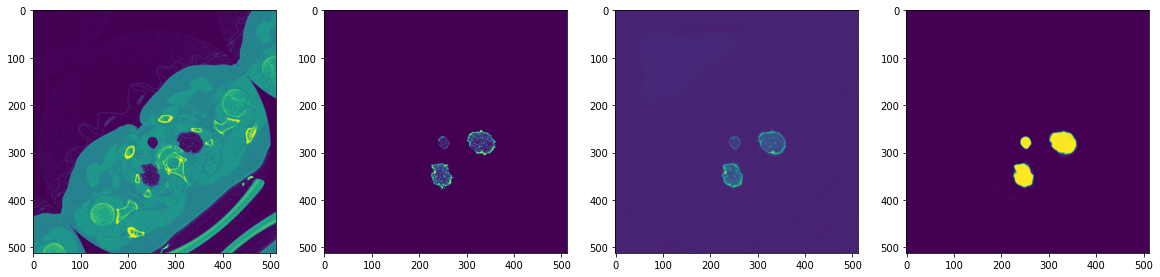

In [52]:
ind1 = 0
item_img,mask_img = test_gen[7]
out = model.predict(item_img)
print(out.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:])
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0])
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze())
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze())

In [55]:
model_alt.load_weights('latent.h5')

In [ ]:
item_img,mask_img = test_gen[7]
out,latent = model_alt.predict(item_img)

(8, 32, 32, 256)


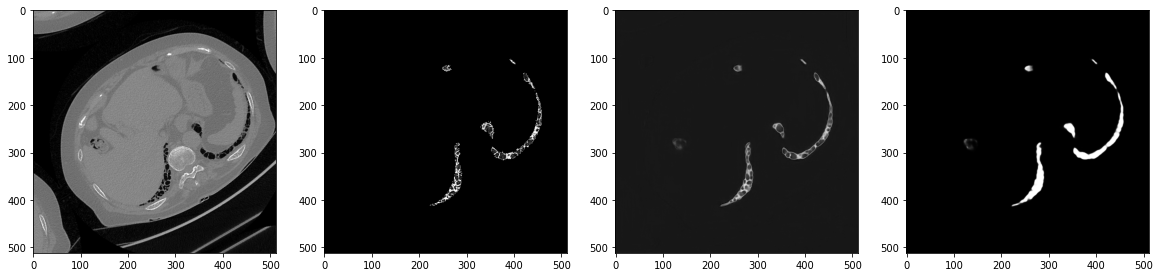

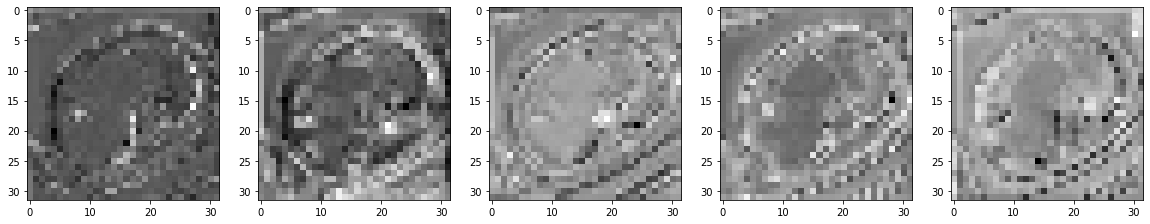

In [67]:
ind1 = 7
kwargs = {'cmap':'gray'}
print(latent.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:],**kwargs)
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0],**kwargs)
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze(),**kwargs)

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.imshow(latent[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(152)
plt.imshow(latent[ind1,:,:,1].squeeze(),**kwargs)
plt.subplot(153)
plt.imshow(latent[ind1,:,:,2].squeeze(),**kwargs)
plt.subplot(154)
plt.imshow(latent[ind1,:,:,3].squeeze(),**kwargs)
plt.subplot(155)
plt.imshow(latent[ind1,:,:,4].squeeze(),**kwargs)


(8, 32, 32, 256)


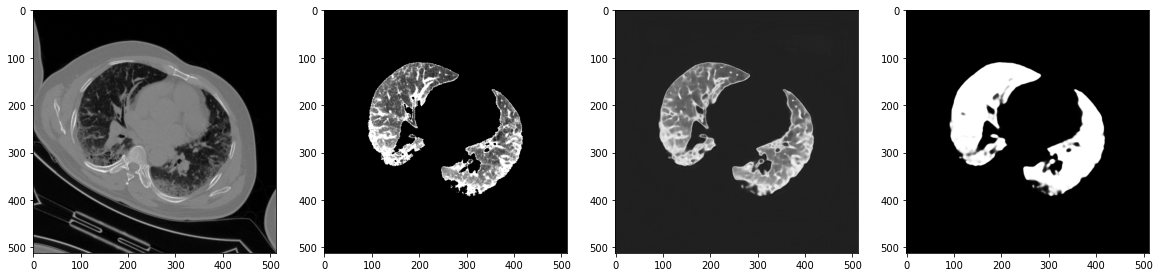

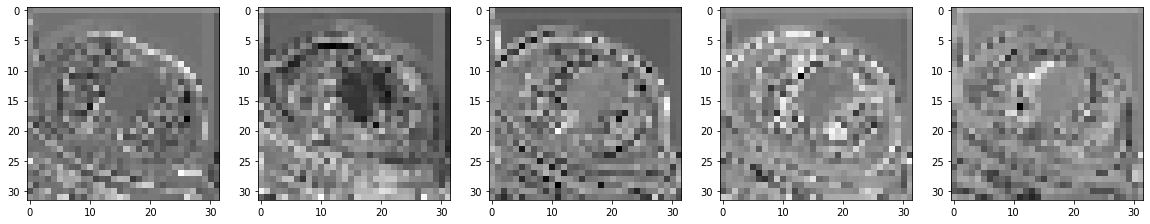

In [62]:
ind1 = 5
kwargs = {'cmap':'gray'}
print(latent.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:],**kwargs)
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0],**kwargs)
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze(),**kwargs)

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.imshow(latent[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(152)
plt.imshow(latent[ind1,:,:,1].squeeze(),**kwargs)
plt.subplot(153)
plt.imshow(latent[ind1,:,:,2].squeeze(),**kwargs)
plt.subplot(154)
plt.imshow(latent[ind1,:,:,3].squeeze(),**kwargs)
plt.subplot(155)
plt.imshow(latent[ind1,:,:,4].squeeze(),**kwargs)
